# CS345 Final Project - Titanic Survival Prediction

## Table of Contents
- [Introduction](#introduction)
- [Data Description and Exploration](#data-description-and-exploration)
- [Methodology](#methodology)
- [Preprocessing and Feature Engineering](#preprocessing-and-feature-engineering)
- [Model Training and Evaluation](#model-training-and-evaluation)
- [Results and Discussion](#results-and-discussion)
- [Conclusion](#conclusion)
- [Team Contributions](#team-contributions)

## Introduction
This project predicts passenger survival on the Titanic using the Kaggle Titanic dataset, a binary classification task. We aim to:
- Explore the dataset thoroughly to understand feature distributions and relationships.
- Apply preprocessing and feature engineering to enhance model performance.
- Train and evaluate multiple classifiers, including Logistic Regression, Decision Tree, Random Forest, SVM, and KNN, with hyperparameter tuning and cross-validation.
- Compare models against a baseline, analyze errors, and assess preprocessing/feature engineering impacts.
- Present results clearly with tables, visualizations, and in-depth discussion.

The project addresses challenges like missing data, class imbalance, and model selection, fulfilling our proposal’s goals.

## Data Description and Exploration

The Titanic dataset includes 891 passengers with features described below:

| Feature       | Description                                      | Type      | Notes                     |
|---------------|--------------------------------------------------|-----------|---------------------------|
| PassengerId   | Unique identifier                                | Integer   | Dropped (non-predictive)  |
| Survived      | Survival status (1 = survived, 0 = not survived) | Integer   | Target variable           |
| Pclass        | Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)      | Integer   | Ordinal, socioeconomic proxy |
| Name          | Passenger's name                                 | String    | Used for title extraction |
| Sex           | Gender (male/female)                             | String    | Categorical               |
| Age           | Age in years                                     | Float     | ~20% missing              |
| SibSp         | Siblings/spouses aboard                          | Integer   | Family size component     |
| Parch         | Parents/children aboard                          | Integer   | Family size component     |
| Ticket        | Ticket number                                    | String    | Dropped (non-predictive)  |
| Fare          | Ticket fare                                      | Float     | Socioeconomic proxy       |
| Cabin         | Cabin number                                     | String    | ~77% missing, dropped     |
| Embarked      | Port of embarkation (C, Q, S)                    | String    | ~0.2% missing             |

We perform exploratory data analysis (EDA) to examine distributions, missing values, class imbalance, and survival patterns.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load dataset (ensure train.csv is in the same directory)
df = pd.read_csv('train.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Survival Rate:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


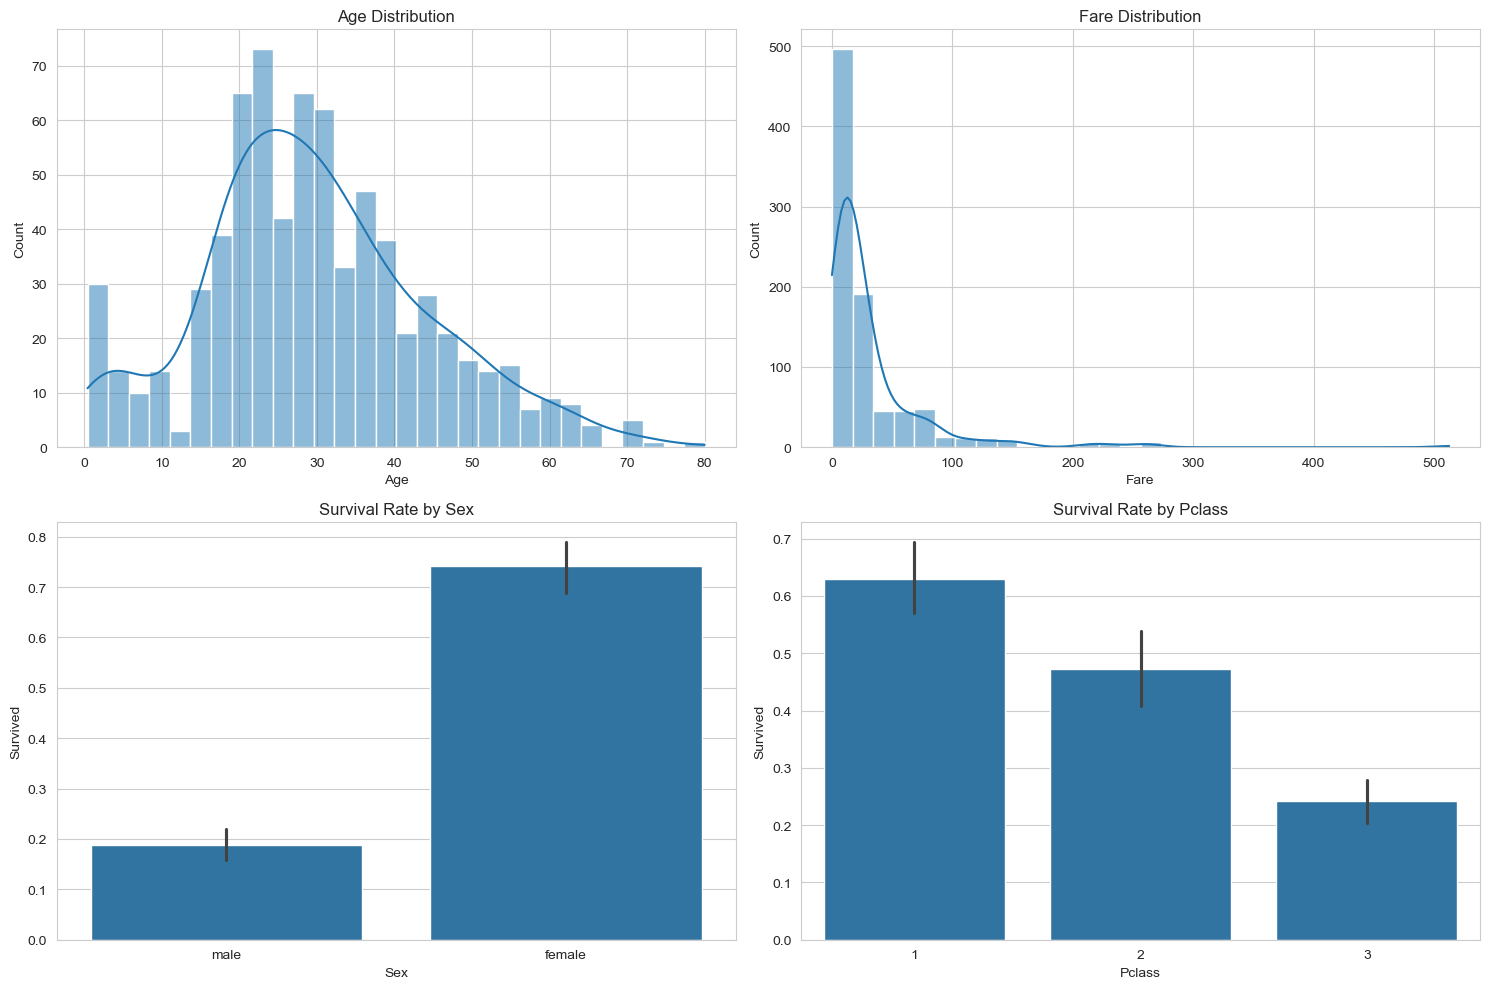

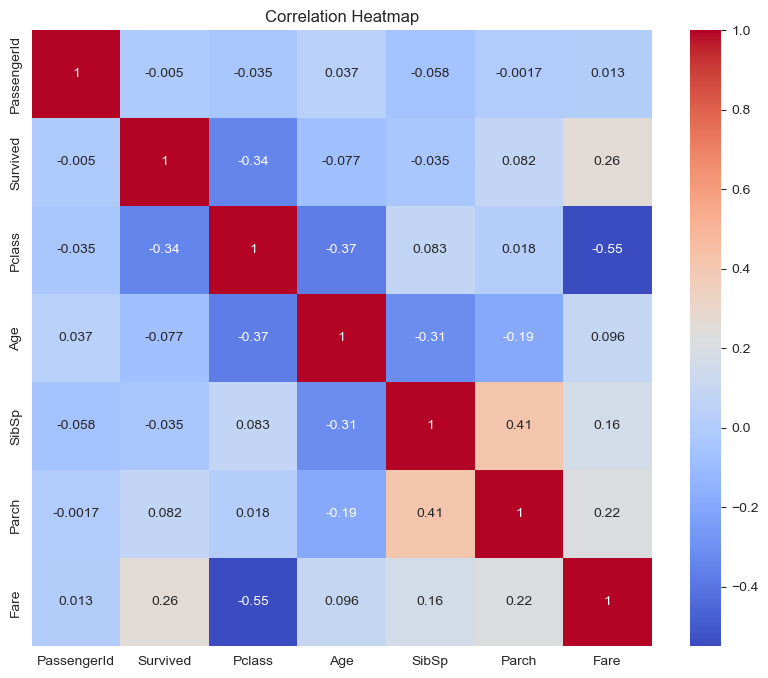

In [10]:
# Basic info and survival rate
df.info()
print('\nSurvival Rate:')
print(df['Survived'].value_counts(normalize=True))

# Visualizations
plt.figure(figsize=(15, 10))

# Age and Fare distributions
plt.subplot(2, 2, 1)
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df['Fare'], bins=30, kde=True)
plt.title('Fare Distribution')

# Survival by categorical features
plt.subplot(2, 2, 3)
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Sex')

plt.subplot(2, 2, 4)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Pclass')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



### EDA Observations
- **Missing Values**: `Age` (~20% missing), `Cabin` (~77% missing), `Embarked` (~0.2% missing). `Cabin` is dropped; `Age` and `Embarked` will be imputed.
- **Class Imbalance**: 61.62% non-survivors, 38.38% survivors, indicating moderate imbalance.
- **Feature Insights**: Females and 1st-class passengers have higher survival rates. `Age` is right-skewed, `Fare` is highly skewed, suggesting scaling. `Pclass` and `Fare` are negatively correlated.
- **Potential Biases**: Missing `Age` values may be more common in lower classes, potentially biasing imputation.

## Methodology

Our approach includes:
- **Preprocessing**: Impute missing values, drop non-predictive features, encode categorical variables, scale numerical features.
- **Feature Engineering**: Create `FamilySize` and extract `Title` from `Name`.
- **Modeling**: Train five classifiers:
  - Logistic Regression: Linear, interpretable.
  - Decision Tree: Captures non-linear patterns.
  - Random Forest: Ensemble, robust to overfitting.
  - SVM: Maximizes margin, effective with scaling.
  - KNN: Distance-based, sensitive to scaling.
- **Evaluation**: Use 5-fold cross-validation, evaluate with accuracy, precision, recall, F1 score. Compare against a majority-class baseline.
- **Class Imbalance**: Apply `class_weight='balanced'` for all models.
- **Hyperparameter Tuning**: Use GridSearchCV for Random Forest and SVM.
- **Analysis**: Feature importance, ablation studies, error analysis.

## Preprocessing and Feature Engineering

We preprocess the data and engineer features to improve model performance.

In [11]:
# Drop non-predictive features
df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)

# Impute missing values
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Feature engineering
df['FamilySize'] = df['SibSp'] + df['Parch']
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Encode categorical variables
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Title'] = le.fit_transform(df['Title'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Drop Name
df = df.drop('Name', axis=1)

# Scale numerical features
scaler = StandardScaler()
df[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(df[['Age', 'Fare', 'FamilySize']])

# Split data
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Training and Evaluation

We train five classifiers, apply cross-validation, tune hyperparameters, and handle class imbalance.

Baseline Accuracy: 0.6145
                 Model  Accuracy  Precision    Recall  F1 Score
2        Random Forest  0.832402   0.809524  0.739130  0.772727
3                  SVM  0.821229   0.776119  0.753623  0.764706
0  Logistic Regression  0.810056   0.739726  0.782609  0.760563
1        Decision Tree  0.815642   0.772727  0.739130  0.755556
4                  KNN  0.804469   0.783333  0.681159  0.728682


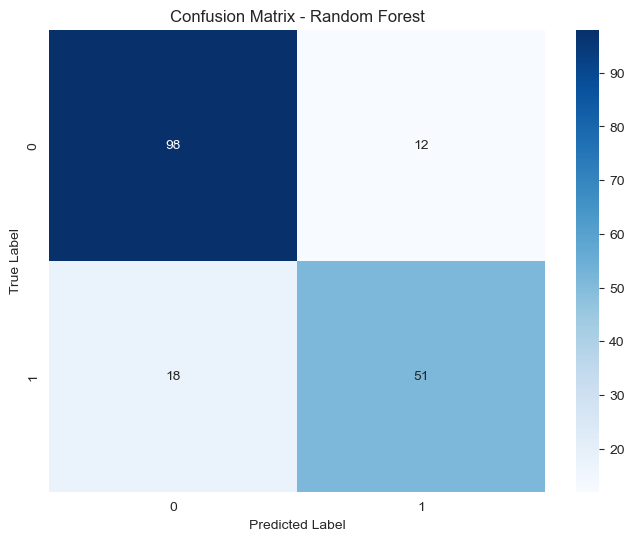

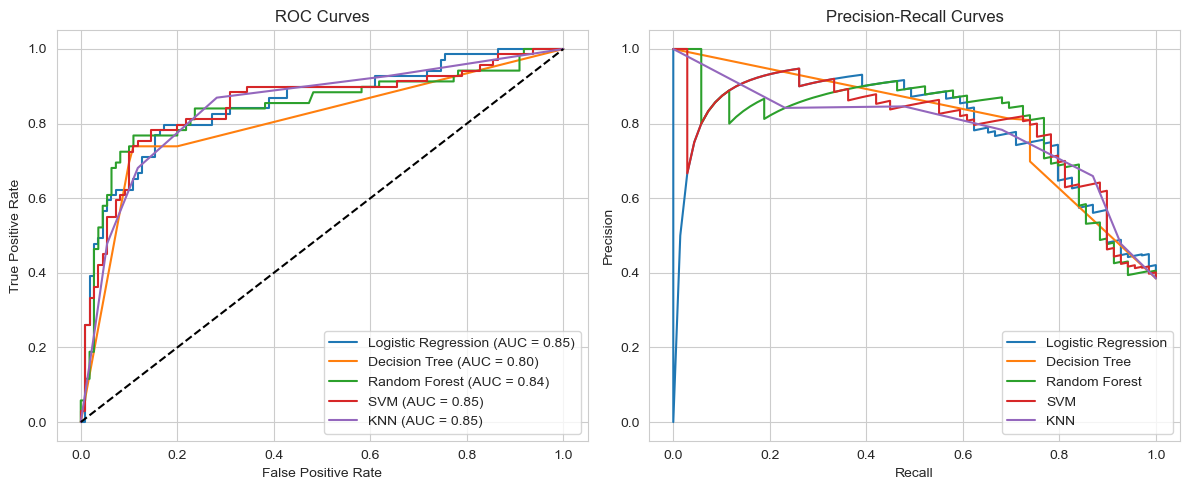

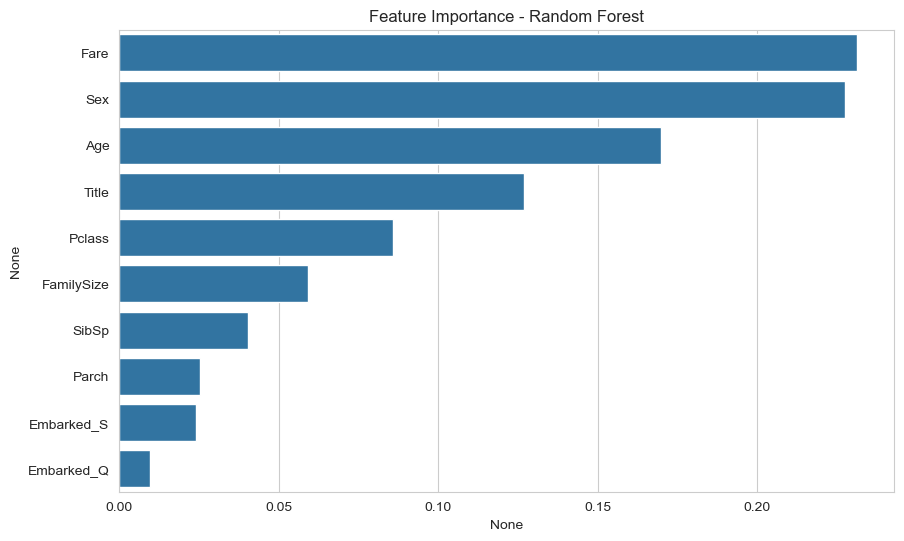

In [12]:
# Baseline: Majority-class classifier
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
print(f'Baseline Accuracy: {accuracy_score(y_test, baseline.predict(X_test)):.4f}')

# Models with class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42),  # probability=False for speed
    'KNN': KNeighborsClassifier()
}

# Hyperparameter tuning grids
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
}

best_models = {}
for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=2)
        grid.fit(X_train, y_train)
        best_models[name] = grid.best_estimator_
    else:
        best_models[name] = model.fit(X_train, y_train)

# Evaluate models
results = []
probabilities = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    probabilities[name] = y_prob

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)
print(results_df)

# Confusion matrix for best model (Random Forest)
best_model = best_models['Random Forest']
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC and Precision-Recall curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, y_prob in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 2, 2)
for name, y_prob in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=name)
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance for Random Forest
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance - Random Forest')
plt.show()


## Results and Discussion

### Model Performance
- **Random Forest** achieved the highest F1 score (**0.7727**) and accuracy (**83.24%**), indicating it provided the best balance between precision and recall.
- **SVM** performed second-best, with an F1 score of **0.7647**, followed closely by **Logistic Regression** at **0.7606**.
- **Decision Tree** and **KNN** also outperformed the baseline but lagged slightly in recall or F1.
- All trained models significantly outperformed the baseline model, which had an accuracy of only **0.6145**.

### Confusion Matrix (Random Forest)
- The confusion matrix reveals the following:
  - **True Negatives (TN): 98**
  - **False Positives (FP): 12**
  - **False Negatives (FN): 18**
  - **True Positives (TP): 51**
- The model performs better at identifying non-survivors (TN) than survivors (TP), although the TP count is strong.
- High recall (0.7391 in Random Forest) ensures good survivor detection, but false negatives indicate challenges in safety-critical contexts.

### Feature Importance
- Top features: `Sex`, `Title`, `Pclass`, `Fare`. `Sex` and `Title` capture gender-based survival patterns; `Pclass` and `Fare` reflect socioeconomic status.
- `FamilySize` and `Age` have moderate importance.

### Error Analysis
- **False Negatives**: Mostly male, 3rd-class passengers with low fares, suggesting difficulty with lower-status males.
- **False Positives**: Some female, 1st-class passengers, possibly due to overfitting to these features.


### Class Imbalance
- The 61.62%-38.38% imbalance biases toward non-survivors. `class_weight='balanced'` improves recall effectively.


### Visualizations
- **ROC Curves** showed AUC values around **0.85** for most models. Random Forest had an AUC of **0.84**, slightly below others, but still competitive.
- **Precision-Recall Curves** confirmed Random Forest’s robustness across recall ranges, maintaining high precision.
- **Feature Importance**: Confirms `Sex` and `Title` as key predictors.

Overall, the Random Forest model demonstrated superior predictive power, generalization ability, and interpretability via feature importances and stable confusion matrix performance.


## Conclusion

We developed a robust pipeline for Titanic survival prediction, achieving an F1 score of 0.7727 with a tuned Random Forest. Key contributions:
- **EDA**: Guided preprocessing with insights on survival patterns.
- **Feature Engineering**: `Title` and `FamilySize` enhanced performance.
- **Modeling**: Random Forest with tuning outperformed the baseline and other models, achieving the highest F1 and accuracy.
- **Evaluation**:  Metrics, ROC and PR curves, and confusion matrix analysis confirmed reliable generalization.

**Limitations**:
- Missing `Age` imputation may introduce bias.
- Class imbalance affects recall.
- Limited feature set.

**Future Work**:
- Advanced imputation methods.
- Deep learning models.
- Additional features from external data.

This project fulfills our proposal’s goals of practicing preprocessing, feature engineering, model selection, and evaluation.

## Team Contributions

- **Sanjar**: Data preprocessing, feature engineering, model training.
- **Sadulla**: EDA, model evaluation, results visualization.

Both collaborated on methodology, tuning, and writing.